# K-Means
k-Means:
> 优点：容易实现<br>
> 缺点：可能收敛到局部最小，在大规模数据集上收敛较慢<br>
> 适用数据类型：数值型数据

k-Means算法的一般流程：
> 1. 收集数据:使用任意方法。
> 2. 准备数据:需要数值型数据来计算距离,也可以将标称型数据映射为二值型数据再用于距离计算。
> 3. 分析数据:使用任意方法。
> 4. 训练算法:不适用于无监督学习,即无监督学习没有训练过程。
> 5. 测试算法:应用聚类算法、观察结果。可以使用量化的误差指标如误差平方和(后面会介绍)来评价算法的结果。
> 6. 使用算法:可以用于所希望的任何应用。通常情况下,簇质心可以代表整个簇的数据来做出决策。

## 1. 算法实现

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib
import json

In [12]:
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    # 书中大量使用mat数据，感觉麻烦，直接使用np.array数组，需要的话再进行转换
    return np.array(dataMat)

def distEclud(vecA, vecB):
    """计算两个样本的距离"""
    
    return np.sqrt(np.sum(np.power(vecA - vecB, 2)))

def randCent(dataSet, k):
    """
    初始化k个质心，随机质心必须在这个数据集的边界范围之内。
    可以通过找到数据集每一列的最大值和最小值
    来完成。然后生成0到1.0之间的随机数并通过最小值和取值范围来完成范围内取值。
    """
    
    n = dataSet.shape[1]
    centroids = np.zeros((k, n))
    for j in range(n):
        # 计算每列的最小值
        minJ = min(dataSet[:, j])
        # 计算每列的取值范围
        rangeJ = float(max(dataSet[:, j]) - minJ)
        # 在数据集范围内生成随机点
        centroids[:, j] = minJ + rangeJ * np.random.rand(k)
    return centroids

In [13]:
datMat = np.mat(loadDataSet('testSet.txt'))
min(datMat[:, 0]), min(datMat[:, 1]), max(datMat[:, 1]), max(datMat[:, 0])

(matrix([[-5.379713]]),
 matrix([[-4.232586]]),
 matrix([[5.1904]]),
 matrix([[4.838138]]))

In [14]:
randCent(datMat, 2)

array([[-0.79050175,  3.90434239],
       [-3.5898987 ,  4.9553123 ]])

In [15]:
distEclud(datMat[0], datMat[1])

5.184632816681332

函数测试完成，下面实现K-Means算法：

In [52]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    """
    创建k个质心，然后将每个点分配到最近的质心，再使用平均值重新计算质心。
    """
    m = dataSet.shape[0]
    # 初始化k个质心
    centroids = createCent(dataSet, k)
    # 初始化记录列表，主要记录每个点所属的簇，和该点到质心的距离平方作为误差值
    clusterAssment = np.zeros((m, 2))
    # 创建停止变量，当所有样本点经过距离计算所分配的质心无需改变的时候就可以停止迭代了
    clusterChanged = True
    while clusterChanged:
        # 先将其置为否，如果不改变就停止迭代
        clusterChanged = False
        for i in range(m):
            # 对每个样本点都要重新计算距离最小的质心，所以每个样本都要初始化一次
            minDist = np.inf
            minIndex = -1
            for j in range(k):
                # 计算当前样本到当前质心的距离
                distJI = distMeas(centroids[j, :], dataSet[i, :])
                if distJI < minDist:
                    # 更新当前样本的最小距离和分配的质心
                    minDist = distJI
                    minIndex = j
            # 跳出质心的循环，更新记录列表里面的值
            # 如果当前样本点在记录列表里的质心索引和上面不符，则还需要进一步迭代，将停止变量置真。
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
            # 更新记录列表里当前样本点的值
            clusterAssment[i, :] = minIndex, minDist ** 2
        # 对每一个簇，需要计算其中所有点的均值并更新所分配的质心
        for cent in range(k):
            # 取出在记录列表第一列的索引值为当前质心的点
            ptsInClust = dataSet[np.nonzero(clusterAssment[:, 0] == cent)]
            # 更新质心
            centroids[cent, :] = np.mean(ptsInClust, axis=0)
    return centroids, clusterAssment

In [76]:
myCentroids, clustAssing = kMeans(datMat, 4)

<class 'numpy.ndarray'>


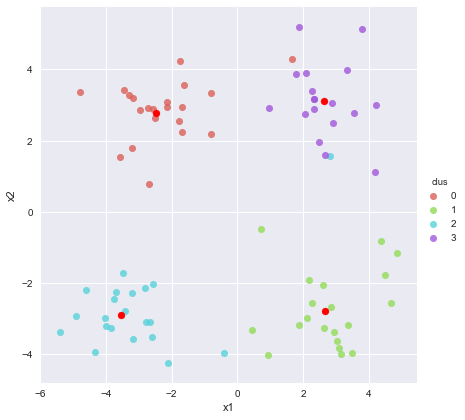

In [80]:
pltdf = pd.DataFrame(datMat)   # 转化成Dataframe
# 由于目前还不知道怎么直接在np.array上增加元素，所以先转换成列表
label = list(np.array(clustAssing[:, 0]).ravel().astype(int))
label.insert(0, 0)
# 转换成DataFrame，然后和上面得pltdf组成一个完整得DataFrame
labeldf = pd.DataFrame(label)
pltdata = pd.merge(pltdf, labeldf, left_index=True, right_index=True)
pltdata.columns=['x1', 'x2', 'clus']   # 设置列标签
sns.set(context='notebook', style='darkgrid', palette=sns.color_palette('hls', 4))

sns.lmplot('x1', 'x2', data=pltdata,
           hue='clus', 
           size=6, fit_reg=False, scatter_kws={"s": 50})
plt.scatter(np.array(myCentroids[:, 0]), np.array(myCentroids[:, 1]), c='r')
plt.show()

## 2. 二分k-Means算法
为克服K-均值算法收敛于局部最小值的问题,有人提出了另一个称为二分K-均值(bisecting K-means)的算法。该算法首先将所有点作为一个簇,然后将该簇一分为二。之后选择其中一个簇继续进行划分,选择哪一个簇进行划分取决于对其划分是否可以最大程度降低SSE的值。上述基于SSE的划分过程不断重复,直到得到用户指定的簇数目为止。

In [87]:
def biKmeans(dataSet, k, distMeas=distEclud):
    m = dataSet.shape[0]
    # 初始化记录列表，主要记录每个点所属的簇，和该点到质心的距离平方作为误差值
    clusterAssment = np.zeros((m, 2))
    # 将整个数据集的均值点作为初始质心
    # 书中使用的dataSet时矩阵形式，所以后面会跟个索引[0]，我们使用np.array则不需要
    centroid0 = np.mean(dataSet, axis=0).tolist()
    # 将初始质心保存到一个列表里
    centList = [centroid0]
    # 计算数据集中所有样本点到初始质心的平方误差，保存在记录列表的第二列里
    for j in range(m):
        clusterAssment[j, 1] = distMeas(np.mat(centroid0), dataSet[j, :]) ** 2
    # 对簇不停的划分，直到得到想要的质心数量为止
    while len(centList) < k:
        # 初始化数据集的总误差，用来比较划分前后的SSE
        lowestSSE = np.inf
        # 遍历簇列表中所有的簇来决定最佳的划分，依据是划分完成后的误差值和当前误差值比较
        for i in range(len(centList)):
            # 对第i个簇，也就是第i个质心所属的数据集
            # 把它看作一个独立的数据集执行k-Means算法，得到两个小簇。
            # 首先取出数据集中属于当前簇的样本子集
            ptsInCurrCluster = np.mat(dataSet[np.nonzero(clusterAssment[:, 0] == i), :])
            # 进行划分
            # centroidMat：基于当前子集的两个质心，splitClutAss：当前子集划分完成后的两个簇标记及误差
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            # 计算当前子集误差值和除第i个簇之外的数据集误差
            sseSplit = np.sum(splitClustAss[:, 1])
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:, 0] != i), :])
            print('sseSplit, and notSplit: ', sseSplit, sseNotSplit)
            # 如果这次的划分得到的误差小于之前的误差，那么保存本次划分
            if sseSplit + sseNotSplit < lowestSSE:
                # 更新最佳的待划分簇
                bestCentToSplit = i
                # 更新待划分簇的划分点
                bestNewCents = centroidMat
                # 保存此次划分的误差
                bestClustAss = splitClustAss.copy()
                # 更新误差
                lowestSSE = sseSplit + sseNotSplit
        # 对第i个簇操作完毕，质心数目加一回到主循环
        # 更新簇划分结果
        # 在调用k-Means算法，k=2时，会把数据集划分为编号为0, 1的两个簇，用它们更新即可
        # 假设原先有2两个质心，这里增加了一个质心，len(centList)总比质心标号大1
        # 新划分的数据集编号为0的用i作为编号不变，为1的用centList的长度作为编号，实现新分配编号的目的
        bestClustAss[np.nonzero(bestClustAss[:, 0] == 1), 0] = len(centList)
        bestClustAss[np.nonzero(bestClustAss[:, 0] == 0), 0] = bestCentToSplit
        print('the bestCentToSplit is: ', bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        # 更新质心列表，第i个质心作为第一个质心
        # 更新上面新增编号的为第二个质心
        centList[bestCentToSplit] = bestNewCents[0, :].tolist()
        centList.append(bestNewCents[1, :].tolist())
        # 重新分配当前质心以及SSE
        clusterAssment[np.nonzero(clusterAssment[:, 0] == bestCentToSplit), :] = bestClustAss
    return np.mat(centList), clusterAssment

In [102]:
datMat3 = loadDataSet('testSet2.txt')
centList, myNewAssments = biKmeans(datMat3, 3)
centList

sseSplit, and notSplit:  453.0334895807502 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
sseSplit, and notSplit:  77.59224931775066 49.157249444125355
sseSplit, and notSplit:  12.753263136887313 423.87624013662486
the bestCentToSplit is:  0
the len of bestClustAss is:  40


matrix([[ 2.93386365,  3.12782785],
        [-0.45965615, -2.7782156 ],
        [-2.94737575,  3.3263781 ]])

## 3. 对地图上的点进行聚类

In [ ]:
def geoGrab(stAddress, city):
    apiStem = 'http://where.yahooapis.com/geocode'
    params = {}
    params['flags'] = 'J'
    params['appid'] = 'ppp68N8t'
    params['location'] = '%s %s' % (stAddress, city)
    url_params = urllib.urlencode(params)
    yahooApi = api